# Copyright
<pre>
This notebook was created as part of the "Deep learning / VITMMA19" class at
Budapest University of Technology and Economics, Hungary,
https://portal.vik.bme.hu/kepzes/targyak/VITMMA19

Any re-use or publication of any part of the notebook is only allowed with the
 written consent of the authors.

2023 (c) Tamás Gábor Csapó (csapot at tmit dot bme dot hu)


Original Variational AutoEncoder example from:

Links:
[Louis Tiao blog] http://louistiao.me/posts/implementing-variational-autoencoders-in-keras-beyond-the-quickstart-tutorial/
[Keras Variational AutoEncoder] https://blog.keras.io/building-autoencoders-in-keras.html
https://raw.githubusercontent.com/fchollet/keras/master/examples/variational_autoencoder.py
[Auto-Encoding Variational Bayes] https://arxiv.org/abs/1312.6114
</pre>

In [1]:
# these should be set up in advance, as they may take a few minutes to install (for plot_model)
!pip install -q pydot
!apt install graphviz

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
graphviz is already the newest version (2.42.2-6).
0 upgraded, 0 newly installed, 0 to remove and 18 not upgraded.


In [2]:
from tensorflow.keras.layers import Input, Dense, Lambda, Layer, Multiply, Add
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.metrics import binary_crossentropy
from tensorflow.keras.utils import plot_model
import tensorflow as tf
import matplotlib.pyplot as plt
from scipy.stats import norm
import numpy as np

In [3]:
# We will create a Variational AutoEncoder that will generate new images for MNIST digits

batch_size = 100
original_dim = 784 # MNIST images size
latent_dim = 2 # latent dimension: 2D
intermediate_dim = 256 # internal 'AutoEncoder'-like compression
epochs = 15


In [4]:
# check the general shape of the VAE network (presentation slide)

# first a simple decoder network

decoder = Sequential([
    Dense(intermediate_dim, input_dim=latent_dim, activation='relu'),
    Dense(original_dim, activation='sigmoid')
])

decoder.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               768       
                                                                 
 dense_1 (Dense)             (None, 784)               201488    
                                                                 
Total params: 202256 (790.06 KB)
Trainable params: 202256 (790.06 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


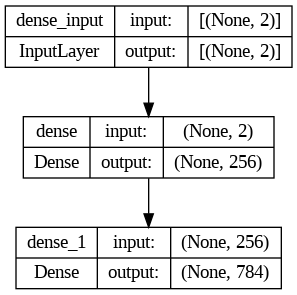

In [5]:
# graphical drawing of decoder model
plot_model(decoder, show_shapes=True, show_layer_names=True)

In [6]:
# encoder network (inference)

# input layer
x = Input(shape=(original_dim,))

# hidden layer
h = Dense(intermediate_dim, activation='relu')(x)

# output layer: mean and log of variance
z_mu = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)


In [7]:
# in the middle of the VAE network, there is a KL-divergence calculation,
# which is solved with a custom layer

class KLDivergenceLayer(Layer):

    """ Identity transform layer that adds KL divergence
    to the final model loss.
    """

    def __init__(self, *args, **kwargs):
        self.is_placeholder = True
        super(KLDivergenceLayer, self).__init__(*args, **kwargs)

    def call(self, inputs):

        mu, log_var = inputs

        kl_batch = - .5 * tf.reduce_sum(1 + log_var -
                                        tf.math.square(mu) -
                                        tf.math.exp(log_var), axis=-1)

        self.add_loss(tf.reduce_mean(kl_batch), inputs=inputs)

        return inputs


In [8]:
# putting it together

# KL-divergence layer
z_mu, z_log_var = KLDivergenceLayer()([z_mu, z_log_var])

# 'var': variance = square of standard deviation
# we calculate the std dev from log vairance
z_sigma = Lambda(lambda t: tf.math.exp(.5*t))(z_log_var)

# noise with normal distribution
eps = Input(shape=(latent_dim,))

# keras Merge layers (Multiply, Add) : reparameterization
z_eps = Multiply()([z_sigma, eps])
z = Add()([z_mu, z_eps])

# decoder
x_pred = decoder(z)

In [9]:
# custom loss: NLL

# log_pθ(x|z)
def nll(y_true, y_pred):
    """ Negative log likelihood (Bernoulli). """

    # keras.losses.binary_crossentropy gives the mean
    # over the last axis. we require the sum
    return tf.reduce_sum(binary_crossentropy(y_true, y_pred), axis=-1)

In [10]:
# full VAE model
vae = Model(inputs=[x, eps], outputs=x_pred)
vae.compile(optimizer='rmsprop', loss=nll)

In [11]:
vae.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 784)]                0         []                            
                                                                                                  
 dense_2 (Dense)             (None, 256)                  200960    ['input_1[0][0]']             
                                                                                                  
 dense_3 (Dense)             (None, 2)                    514       ['dense_2[0][0]']             
                                                                                                  
 dense_4 (Dense)             (None, 2)                    514       ['dense_2[0][0]']             
                                                                                              

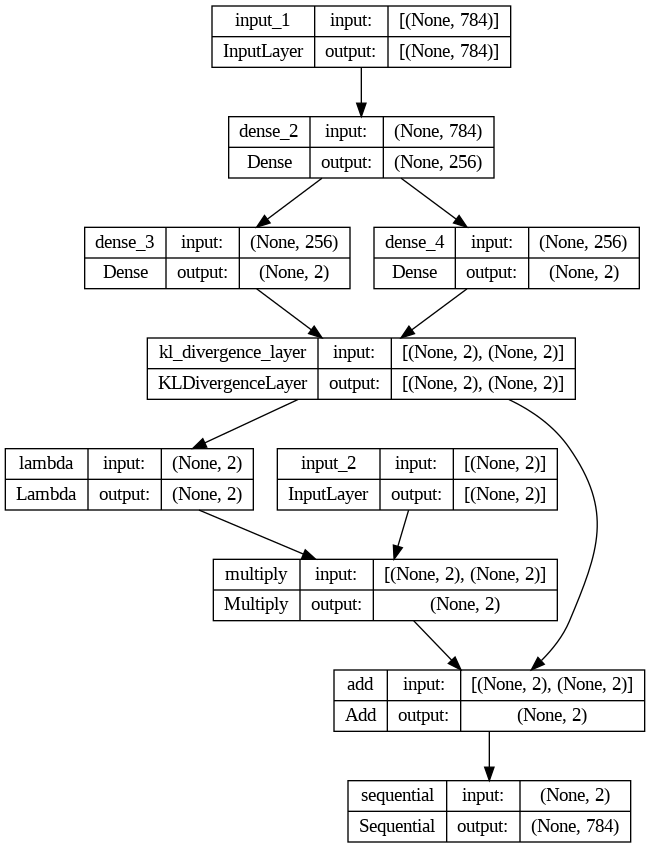

In [12]:
# let's compare our net with the general shape of the VAE,
# (presentation slide)

plot_model(vae, show_shapes=True, show_layer_names=True)

In [ ]:
from keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.reshape(-1, original_dim) / 255.
x_test = x_test.reshape(-1, original_dim) / 255.

11490434/11490434 [==============================] - 1s 0us/step


In [ ]:
noise_train = np.random.normal(size=[x_train.shape[0], latent_dim])
noise_test = np.random.normal(size=[x_test.shape[0], latent_dim])

In [ ]:
# VAE training: input and target/output are the same

vae.fit([x_train, noise_train],
        x_train,
        shuffle=True,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=([x_test, noise_test], x_test))

Epoch 1/15
600/600 [==============================] - 6s 5ms/step - loss: 27.0613 - val_loss: 24.5881
Epoch 2/15
600/600 [==============================] - 2s 4ms/step - loss: 24.4542 - val_loss: 24.3391
Epoch 3/15
600/600 [==============================] - 4s 7ms/step - loss: 24.1977 - val_loss: 24.1359
Epoch 4/15
600/600 [==============================] - 5s 8ms/step - loss: 24.0267 - val_loss: 23.9876
Epoch 5/15
600/600 [==============================] - 4s 7ms/step - loss: 23.8972 - val_loss: 23.8695
Epoch 6/15
600/600 [==============================] - 4s 6ms/step - loss: 23.7927 - val_loss: 23.8216
Epoch 7/15
600/600 [==============================] - 5s 8ms/step - loss: 23.7052 - val_loss: 23.7555
Epoch 8/15
600/600 [==============================] - 3s 5ms/step - loss: 23.6317 - val_loss: 23.7298
Epoch 9/15
600/600 [==============================] - 2s 4ms/step - loss: 23.5697 - val_loss: 23.7123
Epoch 10/15
600/600 [==============================] - 2s 4ms/step - loss: 23.5178

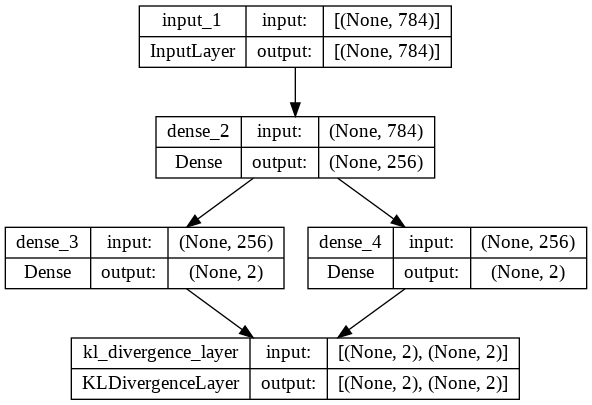

In [ ]:
# evaluating the model

# encoder: original image -> latent distribution (2D)
encoder = Model(x, z_mu)

plot_model(encoder, show_shapes=True, show_layer_names=True)

100/100 [==============================] - 0s 1ms/step


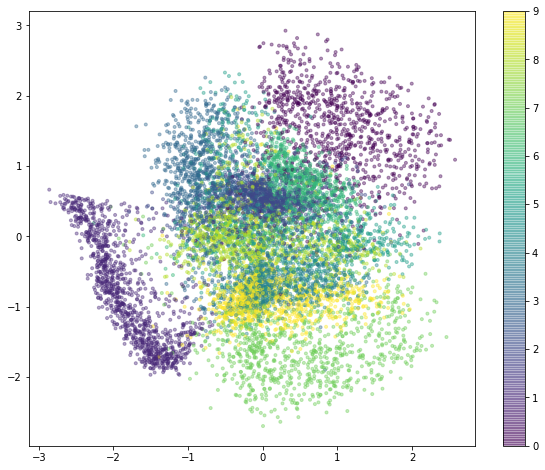

In [ ]:
# drawing digit classes in 2D, in latent space
# it is worth noticing that each group of digits (different colours)
# are quite distinct

# encoder: original image -> latent distribution (2D)

z_test = encoder.predict(x_test, batch_size=batch_size)
plt.figure(figsize=(10, 8))
plt.scatter(z_test[:, 0], z_test[:, 1], c=y_test,
            alpha=.4, s=3**2, cmap='viridis')
plt.colorbar()
plt.show()

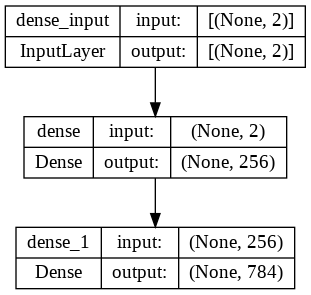

In [ ]:
# decoder (just to remember)
# from 2D latent representation, it can generate new digits

plot_model(decoder, show_shapes=True, show_layer_names=True)


1/1 [==============================] - 0s 41ms/step


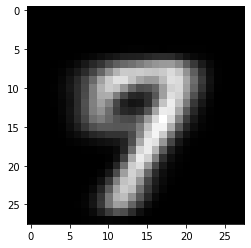

In [ ]:
# generating random images from noise input
# (you can run multiple times)
z_sample = norm.ppf(np.random.rand(1,2))
generated_digit = decoder.predict(z_sample)
plt.imshow(generated_digit.reshape(28,28), cmap='gray')
plt.show()

1/1 [==============================] - 0s 14ms/step


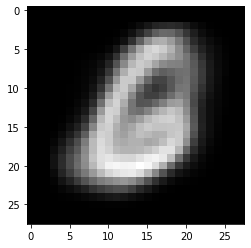

In [ ]:
# generating random images from noise input
# (you can run multiple times)
z_sample = norm.ppf(np.random.rand(1,2))
generated_digit = decoder.predict(z_sample)
plt.imshow(generated_digit.reshape(28,28), cmap='gray')
plt.show()

8/8 [==============================] - 0s 2ms/step


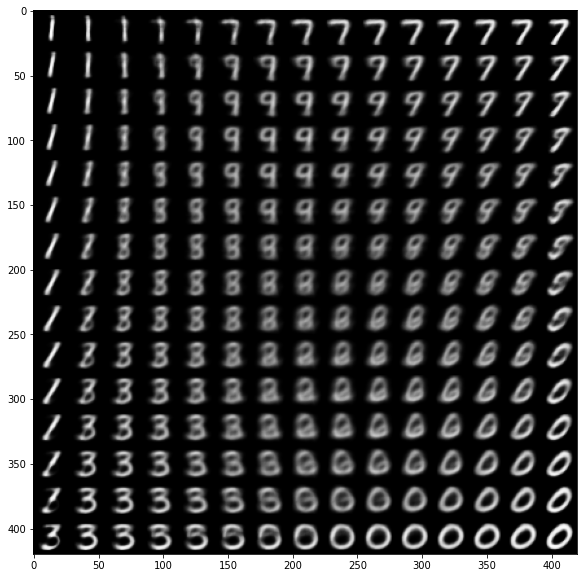

In [ ]:
# digits on a 2D plane surface
n = 15  # 15x15 digit
digit_size = 28

# linearly spaced coordinates on the unit square were transformed
# through the inverse CDF (ppf) of the Gaussian to produce values
# of the latent variables z, since the prior of the latent space
# is Gaussian

z1 = norm.ppf(np.linspace(0.01, 0.99, n))
z2 = norm.ppf(np.linspace(0.01, 0.99, n))

z_grid = np.dstack(np.meshgrid(z1, z2))

x_pred_grid = decoder.predict(z_grid.reshape(n*n, latent_dim)) \
                     .reshape(n, n, digit_size, digit_size)

plt.figure(figsize=(10, 10))
plt.imshow(np.block(list(map(list, x_pred_grid))), cmap='gray')
plt.show()

In [ ]:
# this is the end
# summary: VAE is similar to AE (in the name)
# but this is generative modeling!